<a href="https://colab.research.google.com/github/vaibhavsundharam/Facial-Key-Points-Detection/blob/master/Facial_Key_Points_Detection_with_image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Facial Key Point Detection with Image Augmentation

This work builds on the previous work with the addition of data augmentation. 

Acknowledgements:
The data set for this competition was graciously provided by Dr. Yoshua Bengio of the University of Montreal. James Petterson.

#Data

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data Files: kaggle competitions download -c facial-keypoints-detection


*   training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
*   test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels



In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection

/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection


In [ ]:
#Run the following code to provide the config path to kaggle.json
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Machine Learning/Kaggle"

In [ ]:
# download the dataset
! kaggle competitions download -c facial-keypoints-detection

SampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
IdLookupTable.csv: Skipping, found more recently modified local copy (use --force to force download)
 72% 43.0M/60.1M [00:00<00:00, 75.3MB/s]
100% 60.1M/60.1M [00:00<00:00, 122MB/s] 
 44% 7.00M/16.0M [00:00<00:00, 69.5MB/s]
100% 16.0M/16.0M [00:00<00:00, 77.9MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training.csv            

Archive:  test.zip
  inflating: test.csv                

2 archives were successfully processed.


#General initializations

In [ ]:
import torch
import sys
import os
from __future__ import print_function, division
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import re
import pandas as pd
import numpy as np


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode


In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Set device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#Data Preprocessing

In [ ]:
# Loading the csv files (give path to your cvs files)
train_csv=pd.read_csv("/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/training.csv")
test_csv=pd.read_csv("/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/test.csv")
IdLookupTable_csv=pd.read_csv("/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/IdLookupTable.csv")

In [ ]:
# exploring the train data, each row is an example
train_csv.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


As mentiones in the data section the training file has some data missing. So the nect step is to figure out the number of missing values. The following code does that.


In [ ]:
# total number of missing values
print(f"The total number of missing values in the train dataset is/are: {train_csv.isnull().sum().sum()}")

The total number of missing values in the train dataset is/are: 105412


Some of the most common ways of dealing with missing data are.


*   Replacing
*   Deleting entries with missing values (in is not usually preferred as it reduced the number of training examples)

We perform replacement, in which we replace the missing value with mean.


In [ ]:
# Replace using mean and getting feature list
key_points=list()
for column in train_csv: # itterating over each column
  if column!="Image":      
    key_points.append(column)
    mean=train_csv[column].mean() 
    train_csv[column].fillna(mean, inplace=True) # replacing empty value with the mean 
   

print(f"The key point  list is: {key_points}")

The key point  list is: ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']


In [ ]:
#  Checking again to see the number of missing values
print(f"The total number of missing values in the train dataset is/are: {train_csv.isnull().sum().sum()}")

The total number of missing values in the train dataset is/are: 0


Now we will split the training data into two parts, one will be used for training the neural network and the other will be used for validation. 


In [ ]:
mask = np.random.rand(len(train_csv)) <=0.8  # approx 80% in training and 20% in validation
train_split=train_csv[mask]
val_split=train_csv[~mask]

# saving the train and validation split (the files will be saved in your working directory)
train_split.to_csv("train_split.csv", index= False)
val_split.to_csv("val_split.csv", index= False)

#Data Loading and Data Augmentation

In [ ]:
# custom dataset 
from torch.utils.data import Dataset, DataLoader


class faces(Dataset):
  def __init__(self, csv_loc, p=0.5, transform = None):
    self.csv=pd.read_csv(csv_loc)   
    self.transform =  transform
    self.p=p  

  def __len__(self):
    return len(self.csv)

  def image_normalize(self, sample): # image normalization
    mu     = 0      # mean value
    sigma  = 0      # standard deviation        
    X_norm = 0
    mu=np.mean(sample)
    sigma=np.std(sample)
    X_norm=(sample-mu)/sigma      
    return X_norm

  def flip(self, image, x, y): # horizontal flipping
    image_flip=np.flip(image, axis=1)
    x=96-x
    y=y # flipping does not alter y axis
    return image_flip.copy(), x, y     

  def __getitem__(self, idx):
    image=self.image_normalize(np.array(self.csv.iloc[idx][-1].split(" "), dtype="float").reshape(96,96))  # normalization
    
    
    key_points=np.array(self.csv.iloc[idx][:-1], dtype="float")   # x, y key point pair of the features
    key_points_x=np.take(key_points, range(0, 30, 2)) # taking x co-ordinate of the features
    key_points_y=np.take(key_points, range(1, 30, 2)) # taking y co-ordinate of the features
    key_points_x_y= np.concatenate([key_points_x, key_points_y])  # concatinating x and y features    

    if torch.rand(1) < self.p: # flipping
      image, key_points_x, key_points_y= self.flip(image=image, x=key_points_x, y= key_points_y)
      key_points_x_y= np.concatenate([key_points_x, key_points_y])  # concatinating x and y features      
      
    
    return self.transform(image), key_points_x_y  
    

In [ ]:
train_dataset=faces(csv_loc="/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/train_split.csv", p=0.5, transform = transforms.Compose([transforms.ToTensor()]))
val_dataset= faces(csv_loc="/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/val_split.csv", p=0.5, transform = transforms.Compose([transforms.ToTensor()]))

In [ ]:
print(f"Number of examples in training dataset: {len(train_dataset)}")
print(f"Number of examples in validation dataset: {len(val_dataset)}")

Number of examples in training dataset: 5657
Number of examples in validation dataset: 1392


#Data Exploration

Let us look at an image in the traing dataset.

In [ ]:
def flip_(sample, x, y): # horizontal flipping
  image_flip = np.flip(sample, axis=1)
  x=96-x
  y=y
  x_y = zip(x, y)
  for x, y in x_y:
    image_flip[y][x] = 1
  return image_flip 

In [ ]:
def image_features(sample, x, y): # image features
  x_y=zip(x, y)
  for x, y in x_y:
    sample[y][x]=1
  return sample

In [ ]:
def image_show(sample, csv_loc):
  fig, axs= plt.subplots(1, 3, figsize=(15,15)) 
  csv=pd.read_csv(csv_loc)
  Image=np.array(csv.iloc[sample][-1].split(" "), dtype="float").reshape(96,96)
  key_points = np.array(csv.iloc[sample][:-1], dtype="int32")    

  key_points_x=np.take(key_points, range(0, 30, 2))
  key_points_y=np.take(key_points, range(1, 30, 2)) 

  image_with_key_points =  image_features(sample= Image.copy(), x= key_points_x, y= key_points_y)
  image_flip = flip_(sample= Image.copy(), x= key_points_x, y= key_points_y)

  axs[0].imshow(Image)
  axs[0].set_title("Original Image")
  axs[1].imshow(image_with_key_points)  
  axs[1].set_title("Image with key points")
  axs[2].imshow(image_flip)  
  axs[2].set_title("Horizontal flipping")

  return Image, key_points

Sample image number: 4065



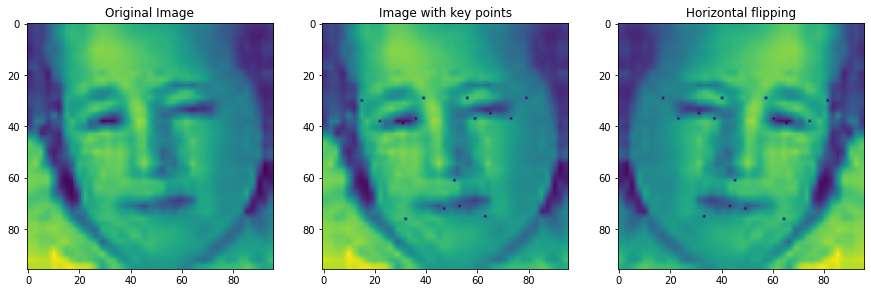

In [ ]:
sample=np.random.randint(0, len(train_dataset)) # randomly selecting an example from train_split
print(f"Sample image number: {sample}\n")
image ,feature=image_show(sample, csv_loc="/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/train_split.csv")

#Helper functions

In [ ]:
def cal_loss(model, loader, criterion, eps=1e-6):
  loss_total=0 
  total_step=len(loader)

  for x, y in loader:
    x=x.to(device=device, dtype=torch.float)
    y=y.to(device=device, dtype=torch.long)
    y_pred=model(x)                  
    loss=torch.sqrt(criterion(y_pred, y) + eps) 
    loss_total+=loss.item()
  
  return (loss_total/total_step)

In [ ]:
# solver function for Neural Network

def Solver_NN(model, train_loader, val_loader, optim, criterion, device, scheduler, print_every=10, epoch=51, lr=1e-1):
  print("Solver Initiated")  
  model=model.to(device) # sending model to GPU
  if device =="cpu":
    print("Cuda unavailable, model successfully sent to the CPU\n")
  else:
    print("Model successfully sent to the GPU\n")

  print_every=print_every
  total_step = len(train_loader)
  counter=0

  for e in range(epoch):
    running_loss = 0.0    
    epoch_loss=0.0
    for i, (x,y) in enumerate(train_loader):
      optim.zero_grad()
      
      x=x.to(device=device, dtype=torch.float)
      y=y.to(device=device, dtype=torch.float)
     
      #forward pass########
      y_pred=model(x)                  
      loss=torch.sqrt(criterion(y_pred, y))   
      ####################
      
      # backward pass#######     
      loss.backward()
      optim.step()
      ####################      
      running_loss += loss.item()      
      if (i+1) % print_every == 0:       # print every 10
        print ("Epoch [{}/{}], Step [{}/{}] Loss: {}".format(counter+1, epoch, i+1, total_step, running_loss/print_every))
        running_loss = 0.0    
    counter+=1     

    with torch.no_grad():            
      train_loss= cal_loss(model, train_loader, criterion)
      val_loss= cal_loss(model, val_loader, criterion)
      scheduler.step(val_loss)
      print(f"Train loss in epoch {e+1} is {train_loss}") 
      print(f"Validation loss in epoch {e+1} is {val_loss}\n ")         
  return model

# Neural Network

##RESNET

In [ ]:
class Resnet(nn.Module):
  def __init__(self, inp_channels, output, model):
    super().__init__()
    self.inp_channels=inp_channels
    self.output=output
    self.first=nn.Sequential(nn.Conv2d(self.inp_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), 
                                              nn.ReLU(inplace=True))
    self.cnn=nn.Sequential(*(list(model.children())[1:-1]), nn.Flatten())    
    self.fc = nn.Sequential(nn.Linear(512, 512), 
                            nn.ReLU(inplace= True),
                            nn.Dropout(p=0.5), 
                            nn.Linear(512, 128), 
                            nn.ReLU(inplace=True), 
                            nn.Dropout(p=0.3), 
                            nn.Linear(128, self.output))
      

  def forward(self, x):  

    x=self.first(x)
    #print(f"1: {x.shape}")

    x=self.cnn(x)
   #print(f"2: {x.shape}")

    x=self.fc(x)
    #print(f"3 {x.shape}")

    return x

In [ ]:
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=False)
num_input_channels=1 # since it's a black and white image
output= 30  # number of keypoints
model= Resnet(num_input_channels, output, resnet)
print(model)


##VGG

In [ ]:
class VGG(nn.Module):
  def __init__(self, inp_channels, output):
    super().__init__()
    self.inp_channels=inp_channels
    self.output=output

    self.vgg=nn.Sequential(
                      nn.Conv2d(self.inp_channels, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))                      
                                                                                                 
    self.avgpool=nn.AdaptiveAvgPool2d(output_size=(7, 7))
    
    self.classifier= nn.Sequential(
                      nn.Flatten(),
                      nn.Linear(in_features=25088, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=self.output, bias=True))
        
    

  def forward(self, x):  
    

    x=self.vgg(x)
    #print(f"1: {x.shape}")

    x=self.avgpool(x)
    #print(f"2: {x.shape}")

    x=self.classifier(x)
    #print(f"3: {x.shape}")

    

    return x

In [ ]:
num_input_channels=1 # since it's a black and white image
output= 30  # number of keypoints
model= VGG(num_input_channels, output)
print(model)


VGG(
  (vgg): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, ker

#Training

In [ ]:
#  model parameters

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable parameters:",params)

Learnable parameters: 134390750


In [ ]:
#criterion and optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr=0.01
criterion=nn.MSELoss(reduction="mean") # loss criterion 
optim=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01) # optimizer 
scheduler= ReduceLROnPlateau(optim, mode="min", factor=0.1, patience=5, verbose=True)

In [ ]:
# loading training and validation data for the neural network

train_loader=DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1) 
val_loader=DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=1) 

In [ ]:
model=Solver_NN(model, train_loader, val_loader, optim, criterion, device, scheduler, print_every=100, epoch=151, lr=lr)

Solver Initiated
Model successfully sent to the GPU

Epoch [1/151], Step [100/354] Loss: 221.08882804870606
Epoch [1/151], Step [200/354] Loss: 32.91346681594849
Epoch [1/151], Step [300/354] Loss: 39.87628929138184
Train loss in epoch 1 is 30.54349137430137
Validation loss in epoch 1 is 30.76156559209714
 
Epoch [2/151], Step [100/354] Loss: 26.098801059722902
Epoch [2/151], Step [200/354] Loss: 20.155275287628175
Epoch [2/151], Step [300/354] Loss: 18.791162071228026
Train loss in epoch 2 is 20.929052379845224
Validation loss in epoch 2 is 20.36911061166347
 
Epoch [3/151], Step [100/354] Loss: 17.211749095916748
Epoch [3/151], Step [200/354] Loss: 15.108774251937866
Epoch [3/151], Step [300/354] Loss: 18.78422327041626
Train loss in epoch 3 is 15.349316244071487
Validation loss in epoch 3 is 15.25112919423772
 
Epoch [4/151], Step [100/354] Loss: 14.997474422454834
Epoch [4/151], Step [200/354] Loss: 15.958061866760254
Epoch [4/151], Step [300/354] Loss: 14.640524606704712
Train los

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/weights_2.pkl') 

#Testing 

Lets look at the testing data

In [ ]:
test_csv.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [ ]:
test_loader= DataLoader(test_dataset, batch_size= 512, shuffle=True, num_workers=16) 

In [ ]:
with torch.no_grad():
  Y_preds=list()
  for x in test_loader:
    x=x=x.to(device=device, dtype=torch.float)
    y_pred=model(x).to(device="cpu")
    Y_preds.append(y_pred)
    
  Y= torch.cat(Y_preds, dim=0).tolist()
  
  

In [ ]:
lookid_list = list(IdLookupTable_csv['FeatureName'])
imageID = list(IdLookupTable_csv['ImageId']-1)
pre_list = list(Y)

In [ ]:
rowid = IdLookupTable_csv['RowId']
rowid=list(rowid)

In [ ]:
feature = []
for f in list(IdLookupTable_csv['FeatureName']):
    feature.append(lookid_list.index(f))

In [ ]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [ ]:
rowid = pd.Series(rowid,name = 'RowId')

In [ ]:
loc = pd.Series(preded,name = 'Location')

In [ ]:
submission = pd.concat([rowid,loc],axis = 1)

In [ ]:
submission.to_csv('face_key_detection_submission.csv', index = False)
